In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chisquare, kstest, normaltest, shapiro

In [12]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
df = pd.read_csv('source/iris.txt', names=column_names)
df

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [13]:
class_mapping = {
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
}

df['class'] = df['class'].replace(class_mapping)
df

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [14]:
# num_bins = int(1 + np.floor(np.log2(df.shape[0])))
num_bins = 15
num_bins

15

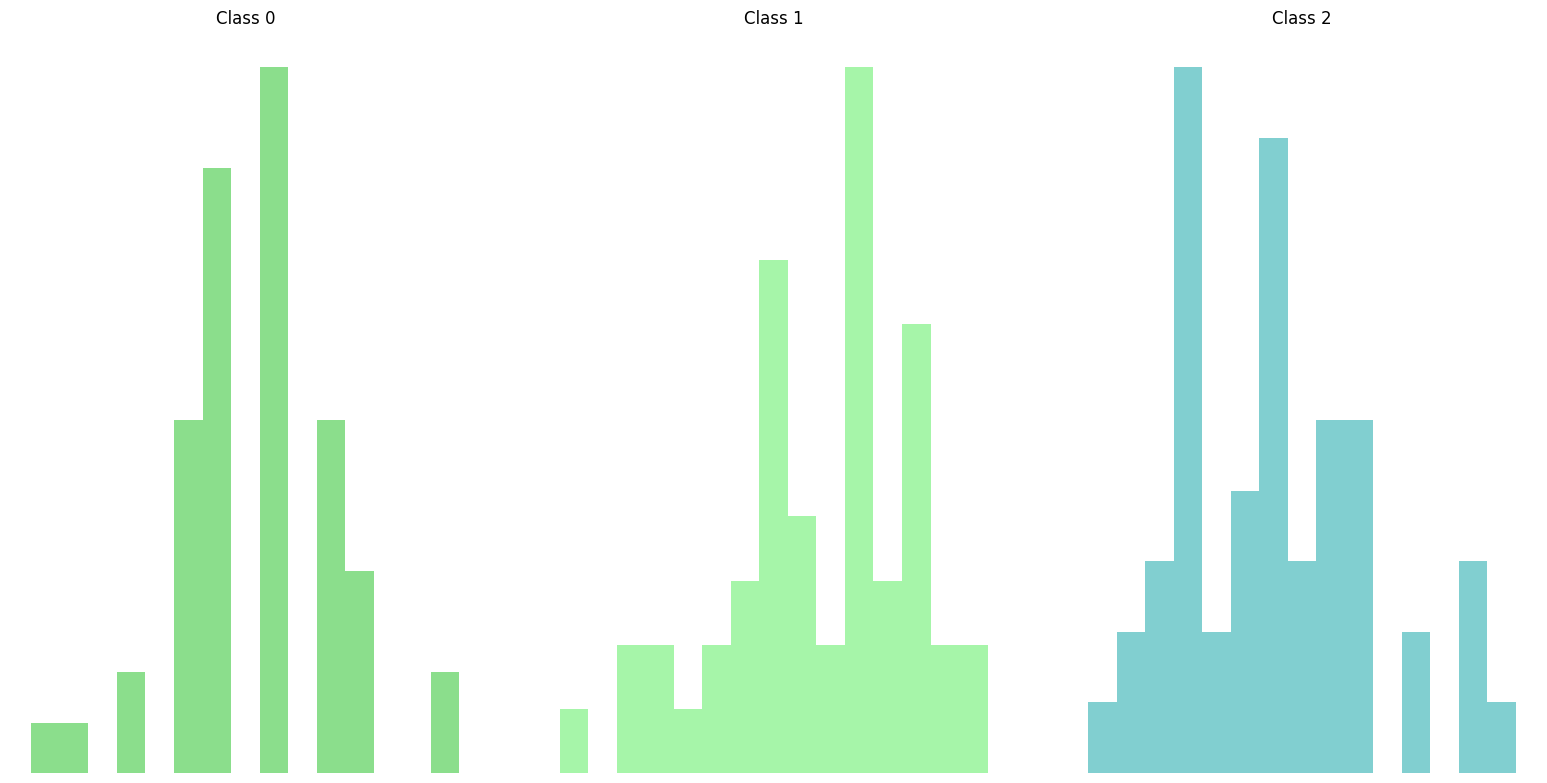

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)
fig.tight_layout()
petal_length_by_classes = {}
freqs_by_classes = {}
bin_edges_by_classes = {}

for class_number, ax in zip(range(min(df['class']), max(df['class']) + 1), axes.flatten()):
    lengths = df[df['class'] == class_number]['petal_length']
    petal_length_by_classes[class_number] = np.array(lengths)
    histogram_length, bin_edges_length = np.histogram(lengths, bins=num_bins)
    freqs_by_classes[class_number] = histogram_length
    bin_edges_by_classes[class_number] = bin_edges_length
    color = np.random.rand(3,)
    ax.hist(lengths, bins=num_bins, color=color)
    ax.set_xlabel('Length')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Class {class_number}')

for ax in axes.flatten():
    ax.axis('off')

In [16]:
for class_number, freq in freqs_by_classes.items():
    new_bin_edges = [-np.inf]  # Начинаем с первой границы
    new_observed_freq = []  # Создаем новый список для наблюдаемых частот
    current_bin_freq = 0  # Счетчик значений в текущем интервале

    for i in range(1, len(bin_edges_by_classes[class_number])):
        current_bin_freq += freq[i - 1]
        if current_bin_freq >= 3:
            new_bin_edges.append(bin_edges_by_classes[class_number][i])
            new_observed_freq.append(current_bin_freq)
            current_bin_freq = 0

    # Последний интервал (если он остался) добавляем в последний интервал
    if current_bin_freq > 0:
        new_observed_freq[-1] += current_bin_freq

    # Преобразуем списки в массивы numpy
    new_observed_freq = np.array(new_observed_freq)
    new_bin_edges = np.array(new_bin_edges)
    new_bin_edges[-1] = np.inf

    freqs_by_classes[class_number] = new_observed_freq / len(petal_length_by_classes[class_number])
    bin_edges_by_classes[class_number] = new_bin_edges

In [17]:
freqs_by_classes

{0: array([0.08, 0.14, 0.24, 0.28, 0.14, 0.12]),
 1: array([0.06, 0.06, 0.1 , 0.16, 0.08, 0.26, 0.06, 0.14, 0.08]),
 2: array([0.06, 0.06, 0.2 , 0.12, 0.18, 0.06, 0.1 , 0.1 , 0.12])}

In [18]:
bin_edges_by_classes

{0: array([-inf, 1.24, 1.36, 1.42, 1.54, 1.66,  inf]),
 1: array([-inf, 3.42, 3.7 , 3.98, 4.12, 4.26, 4.54, 4.68, 4.82,  inf]),
 2: array([-inf, 4.82, 4.98, 5.14, 5.46, 5.62, 5.78, 5.94, 6.1 ,  inf])}

In [19]:
gamma = 0.95

In [23]:
info = pd.DataFrame({'Class': [], 'Mean': [], 'Conf_int for mean': [], 'Std': [], 'Dev': [], 'Conf_int for dev': []})
for class_number, length in petal_length_by_classes.items():
    mean = np.mean(length)
    std_dev = np.std(length)
    dev = np.var(length)
    info.loc[class_number, 'Class'] = class_number
    info.loc[class_number, 'Mean'] = mean
    info.loc[class_number, 'Std'] = std_dev
    info.loc[class_number, 'Dev'] = dev
    n_batch = len(length)
    a_est_left = mean - stats.t.ppf(1 - gamma / 2, n_batch - 1) * std_dev / np.sqrt(n_batch-1)
    a_est_right = mean + stats.t.ppf(1 - gamma / 2, n_batch - 1) * std_dev / np.sqrt(n_batch-1)
    info.loc[class_number, 'Conf_int for mean'] = '(' + str(a_est_left) + '; ' + str(a_est_right) + ')'
    chi_1_batches = stats.chi2.ppf(q=1 - gamma / 2, df=n_batch - 1)
    chi_2_batches = stats.chi2.ppf(q=gamma / 2, df=n_batch - 1)
    d_est_left = n_batch * dev / chi_1_batches
    d_est_right = n_batch * dev / chi_2_batches
    info.loc[class_number, 'Conf_int for dev'] = '(' + str(d_est_left) + '; ' + str(d_est_right) + ')'
info

,Class,Mean,Conf_int for mean,Std,Dev,Conf_int for dev
0,0.0,1.464,(1.462453388207783; 1.465546611792217),0.171767,0.029504,(0.03013476978364819; 0.030912523932879323)
1,1.0,4.260,(4.255811394142878; 4.264188605857122),0.465188,0.216400,(0.22102644323418755; 0.22673095780487687)
2,2.0,5.552,(5.547080622784447; 5.556919377215554),0.546348,0.298496,(0.30487758410181165; 0.31274622911702643)


In [21]:
expected_freq_by_batches = {}
for class_number, freq in freqs_by_classes.items():
    expected_freq = []

    for i in range(len(bin_edges_by_classes[class_number]) - 1):
        lower_bound = bin_edges_by_classes[class_number][i]
        upper_bound = bin_edges_by_classes[class_number][i + 1]
        expected_count = stats.norm.cdf(upper_bound, loc=info.loc[class_number, 'Mean'], scale=info.loc[class_number, 'Std']) - stats.norm.cdf(lower_bound, loc=info.loc[class_number, 'Mean'], scale=info.loc[class_number, 'Std'])
        expected_freq.append(expected_count)

    expected_freq_by_batches[class_number] = expected_freq

In [22]:
for class_number, length in petal_length_by_classes.items():
    chi_squared_statistic, chi_squared_p_value = stats.chisquare(f_obs=freqs_by_classes[class_number], f_exp=expected_freq_by_batches[class_number], ddof=2)
    ks_statistic, ks_p_value = stats.kstest(length, 'norm', args=(info.loc[class_number, 'Mean'], info.loc[class_number, 'Std']))
    omega2_statistic, omega2_p_value = stats.shapiro(length)
    alpha = 0.05
    print('Класс №', class_number)
    if chi_squared_p_value < alpha:
        print("Выборка не имеет нормальное распределение по Пирсону (p-value =", chi_squared_p_value, ")")
    else:
        print("Выборка имеет нормальное распределение по Пирсону (p-value =", chi_squared_p_value, ")")
    if ks_p_value < alpha:
        print("Выборка не имеет нормальное распределение по Колмогорову (p-value =", ks_p_value, ")")
    else:
        print("Выборка имеет нормальное распределение по Колмогорову (p-value =", ks_p_value, ")")
    if omega2_p_value < alpha:
        print("Выборка не имеет нормальное распределение по Шапиро (p-value =", omega2_p_value, ")")
    else:
        print("Выборка имеет нормальное распределение по Шапиро (p-value =", omega2_p_value, ")")

Класс № 0
Выборка имеет нормальное распределение по Пирсону (p-value = 0.987766091724305 )
Выборка имеет нормальное распределение по Колмогорову (p-value = 0.15262135387697784 )
Выборка имеет нормальное распределение по Шапиро (p-value = 0.054648224264383316 )
Класс № 1
Выборка имеет нормальное распределение по Пирсону (p-value = 0.9998874377799385 )
Выборка имеет нормальное распределение по Колмогорову (p-value = 0.45189575170718055 )
Выборка имеет нормальное распределение по Шапиро (p-value = 0.1584763377904892 )
Класс № 2
Выборка имеет нормальное распределение по Пирсону (p-value = 0.9994382609769071 )
Выборка имеет нормальное распределение по Колмогорову (p-value = 0.47673119334727443 )
Выборка имеет нормальное распределение по Шапиро (p-value = 0.10977503657341003 )
